In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS

from pyinterpolate import build_experimental_variogram, TheoreticalVariogram, kriging

# Read Point Measurements and Canvas

In [2]:
readings = pd.read_csv('pm25_year_2021_daily.csv', index_col='name')
canvas = gpd.read_file('hexgrid.shp')
canvas['points'] = canvas.centroid

In [3]:
readings.head()

,01.01.2021,02.01.2021,03.01.2021,04.01.2021,05.01.2021,06.01.2021,07.01.2021,08.01.2021,09.01.2021,10.01.2021,11.01.2021,12.01.2021,13.01.2021,14.01.2021,15.01.2021,16.01.2021,17.01.2021,18.01.2021,19.01.2021,20.01.2021,21.01.2021,22.01.2021,23.01.2021,24.01.2021,25.01.2021,26.01.2021,27.01.2021,28.01.2021,29.01.2021,30.01.2021,31.01.2021,01.02.2021,02.02.2021,03.02.2021,04.02.2021,05.02.2021,06.02.2021,07.02.2021,08.02.2021,09.02.2021,...,24.04.2021,25.04.2021,26.04.2021,27.04.2021,28.04.2021,29.04.2021,30.04.2021,01.05.2021,02.05.2021,03.05.2021,04.05.2021,05.05.2021,06.05.2021,07.05.2021,08.05.2021,09.05.2021,10.05.2021,11.05.2021,12.05.2021,13.05.2021,14.05.2021,15.05.2021,16.05.2021,17.05.2021,18.05.2021,19.05.2021,20.05.2021,21.05.2021,22.05.2021,23.05.2021,24.05.2021,25.05.2021,26.05.2021,27.05.2021,28.05.2021,29.05.2021,30.05.2021,31.05.2021,x,y
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Legnica - Polarna,42.8,55.2,41.9,43.6,17.2,14.5,13.0,22.3,19.5,19.6,31.9,14.1,8.1,15.1,17.4,18.5,33.8,98.6,13.6,12.5,14.3,15.0,13.9,21.0,17.2,22.0,26.0,23.4,17.9,27.2,34.1,79.1,54.7,0.0,11.5,32.3,19.6,20.0,26.3,52.5,...,11.7,7.9,11.3,17.6,19.6,15.4,13.8,NaN,NaN,NaN,NaN,23.0,13.7,9.4,7.6,6.3,8.1,7.6,10.0,7.4,10.8,12.6,13.6,4.8,5.4,7.0,4.4,5.7,5.9,6.1,6.8,5.4,6.1,5.4,5.3,4.6,4.5,3.9,4.752551e+06,3.140166e+06
Osieczów,32.7,27.7,28.4,26.3,11.7,4.8,8.7,13.9,9.8,12.8,21.9,10.7,4.4,7.7,11.6,7.7,17.8,34.2,5.8,5.3,7.5,6.0,6.7,11.3,9.7,13.5,15.4,12.7,12.3,15.5,34.8,71.2,26.6,5.5,7.5,26.1,18.9,16.6,18.8,31.0,...,7.5,6.1,6.9,7.6,13.0,11.9,9.5,NaN,NaN,NaN,NaN,14.2,NaN,NaN,6.7,3.4,5.3,4.5,5.9,6.6,9.7,10.5,10.6,4.4,4.5,7.1,5.3,4.2,4.8,5.0,7.0,5.8,4.8,4.6,5.7,4.3,5.6,5.3,4.699284e+06,3.148150e+06
Wałbrzych - Wysockiego,23.6,54.3,66.3,64.5,11.1,18.4,18.3,17.6,23.1,27.4,27.6,14.0,10.9,10.5,13.6,9.5,77.1,72.5,12.9,11.1,13.2,11.7,19.3,26.0,11.8,12.7,15.2,21.2,28.7,24.1,54.9,56.0,18.1,9.8,13.8,31.9,27.3,24.9,32.8,60.9,...,11.9,13.6,14.7,26.0,35.5,14.2,12.4,NaN,NaN,NaN,NaN,19.1,5.8,10.6,7.7,6.1,7.1,5.5,20.8,7.8,8.5,8.7,12.4,3.1,4.2,5.7,2.9,5.0,6.3,9.8,9.0,5.9,6.2,7.3,5.2,4.9,4.6,4.8,4.762693e+06,3.091949e+06
Wrocław - Na Grobli,28.9,48.1,54.0,57.6,18.9,21.8,17.4,20.9,17.8,17.1,29.2,16.2,9.9,16.3,23.3,14.4,34.7,80.8,18.0,14.1,20.1,14.6,17.8,14.4,14.7,22.6,19.7,27.5,16.1,27.7,41.2,63.3,53.6,15.0,13.9,27.7,21.8,21.5,27.3,54.9,...,9.1,5.2,7.9,18.3,17.3,18.4,10.0,NaN,NaN,NaN,NaN,20.7,11.1,6.2,7.6,4.3,6.0,5.3,11.0,10.6,9.9,11.4,14.6,10.8,5.1,7.2,3.8,4.0,5.0,5.8,6.9,5.5,3.9,4.9,5.4,3.5,3.1,2.6,4.814559e+06,3.134107e+06
Zgorzelec - Bohaterów Getta,34.6,35.9,38.2,34.7,17.5,11.1,15.5,21.8,15.4,18.4,21.0,NaN,9.6,15.0,13.6,NaN,33.7,37.2,10.5,10.2,15.8,12.2,11.9,25.4,19.2,22.2,22.4,21.4,28.7,29.5,59.5,65.6,27.3,12.3,11.6,34.1,27.8,29.0,31.5,43.6,...,11.4,10.1,14.8,12.8,20.8,16.9,15.1,NaN,NaN,NaN,NaN,28.7,14.1,12.9,12.6,9.5,10.2,10.8,14.7,12.9,19.8,26.0,20.0,4.8,9.3,9.0,7.5,7.5,8.0,8.9,10.6,15.4,9.2,8.5,11.1,5.7,8.7,5.6,4.671112e+06,3.127473e+06


In [4]:
canvas.head()

,id,geometry,points
0,1265.0,"POLYGON ((5262483.451 3241159.737, 5262533.545...",POINT (5264567.424 3235499.996)
1,1267.0,"POLYGON ((5266784.217 3208609.593, 5278331.223...",POINT (5272557.720 3198609.593)
2,1266.0,"MULTIPOLYGON (((5267077.091 3228607.316, 52670...",POINT (5268791.749 3214872.652)
3,1269.0,"POLYGON ((5266784.217 3168609.593, 5278331.223...",POINT (5272557.720 3158609.593)
4,1268.0,"POLYGON ((5266784.217 3188609.593, 5278331.223...",POINT (5272557.720 3178609.593)


In [5]:
# Take one reading and x, y columns

In [6]:
df = readings[['01.01.2021', 'x', 'y']]
df.columns = ['pm2.5', 'x', 'y']

In [7]:
df.head()

,pm2.5,x,y
name,,,
Legnica - Polarna,42.8,4.752551e+06,3.140166e+06
Osieczów,32.7,4.699284e+06,3.148150e+06
Wałbrzych - Wysockiego,23.6,4.762693e+06,3.091949e+06
Wrocław - Na Grobli,28.9,4.814559e+06,3.134107e+06
Zgorzelec - Bohaterów Getta,34.6,4.671112e+06,3.127473e+06


# Transform `DataFrame` into `GeoDataFrame`

In [8]:
DATA_CRS = CRS.from_epsg('2180')

In [9]:
df['geometry'] = gpd.points_from_xy(df['x'], df['y'])

/tmp/ipykernel_17499/448585355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = gpd.points_from_xy(df['x'], df['y'])


In [10]:
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=DATA_CRS)

In [11]:
# Remove NaNs

gdf = gdf.dropna()

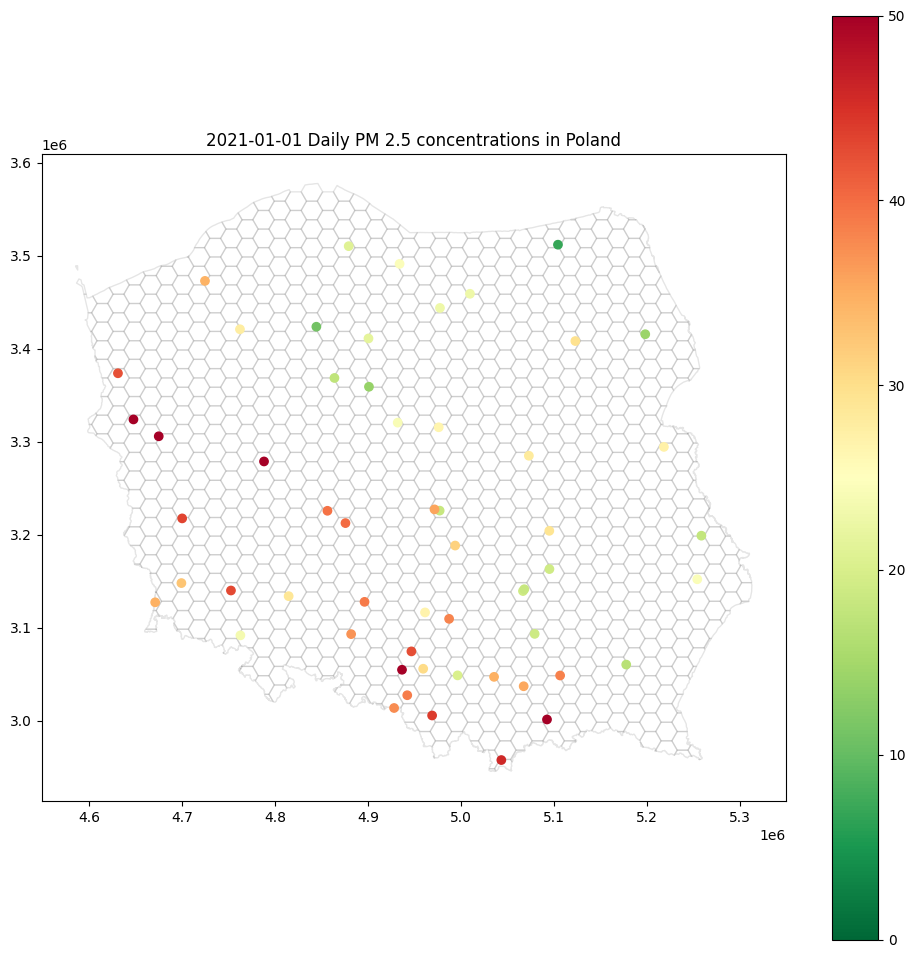

In [12]:
base = canvas.plot(color='white', edgecolor='black', alpha=0.1, figsize=(12, 12))
gdf.plot(ax=base, column='pm2.5', legend=True, vmin=0, vmax=50, cmap='RdYlGn_r')
base.set_title('2021-01-01 Daily PM 2.5 concentrations in Poland');

# Build Variogram Model

In [48]:
km_c = 10**3
STEP_SIZE = km_c * 50
MAX_RANGE = km_c * 400
NEIGHBOURS = 8

In [49]:
arr = gdf[['x', 'y', 'pm2.5']].values

semivar = build_experimental_variogram(input_array=arr, step_size=STEP_SIZE, max_range=MAX_RANGE)

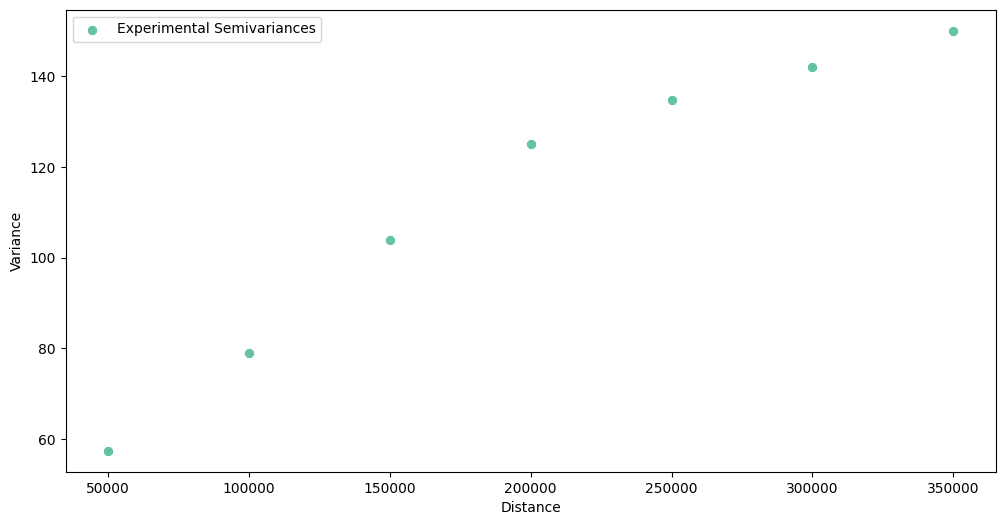

In [50]:
semivar.plot()

In [51]:
ts = TheoreticalVariogram()

In [52]:
ts.autofit(experimental_variogram=semivar, verbose=False)

{'model_type': 'exponential',
 'nugget': 0,
 'sill': 148.20096938775512,
 'rang': 115532.31719150333,
 'fitted_model': array([[5.00000000e+04, 5.20624642e+01],
        [1.00000000e+05, 8.58355732e+01],
        [1.50000000e+05, 1.07744311e+02],
        [2.00000000e+05, 1.21956589e+02],
        [2.50000000e+05, 1.31176145e+02],
        [3.00000000e+05, 1.37156904e+02],
        [3.50000000e+05, 1.41036644e+02]]),
 'rmse': 5.590562271875477,
 'bias': nan,
 'mae': nan,
 'smape': nan}

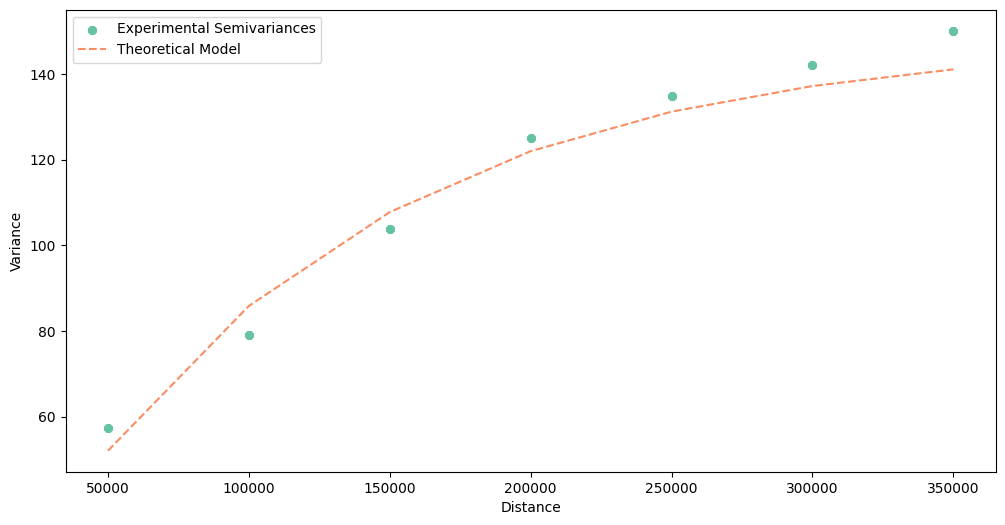

In [53]:
ts.plot()

# Interpolate Missing Values with Kriging

In [54]:
# Predict

pts = list(zip(canvas['points'].x, canvas['points'].y))

In [72]:
predicted = kriging(observations=arr,
                    theoretical_model=ts,
                    points=pts,
                    neighbors_range=MAX_RANGE / 2,
                    no_neighbors=8)

100%|████████████████████████████████████████████████| 1016/1016 [00:00<00:00, 7803.21it/s]


In [73]:
predicted[0]  # pred, err, x (lat), y (lon)

array([2.06460250e+01, 6.16746669e+01, 5.26456742e+06, 3.23550000e+06])

In [74]:
cdf = gpd.GeoDataFrame(data=predicted, columns=['yhat', 'err', 'x', 'y'])
cdf['geometry'] = gpd.points_from_xy(cdf['x'], cdf['y'])
cdf.set_crs(crs=DATA_CRS, inplace=True)

,yhat,err,x,y,geometry
0,20.646025,61.674667,5.264567e+06,3.235500e+06,POINT (5264567.424 3235499.996)
1,19.188504,32.015639,5.272558e+06,3.198610e+06,POINT (5272557.720 3198609.593)
2,19.455376,40.480097,5.268792e+06,3.214873e+06,POINT (5268791.749 3214872.652)
3,22.925139,39.186065,5.272558e+06,3.158610e+06,POINT (5272557.720 3158609.593)
4,20.750549,39.642982,5.272558e+06,3.178610e+06,POINT (5272557.720 3178609.593)
...,...,...,...,...,...
1011,26.975688,105.272167,5.220596e+06,3.008610e+06,POINT (5220596.196 3008609.593)
1012,23.626752,91.398827,5.220596e+06,3.028610e+06,POINT (5220596.196 3028609.593)
1013,30.322156,128.647652,5.221250e+06,2.971454e+06,POINT (5221249.831 2971453.892)
1014,29.045897,118.406420,5.220596e+06,2.988610e+06,POINT (5220596.196 2988609.593)


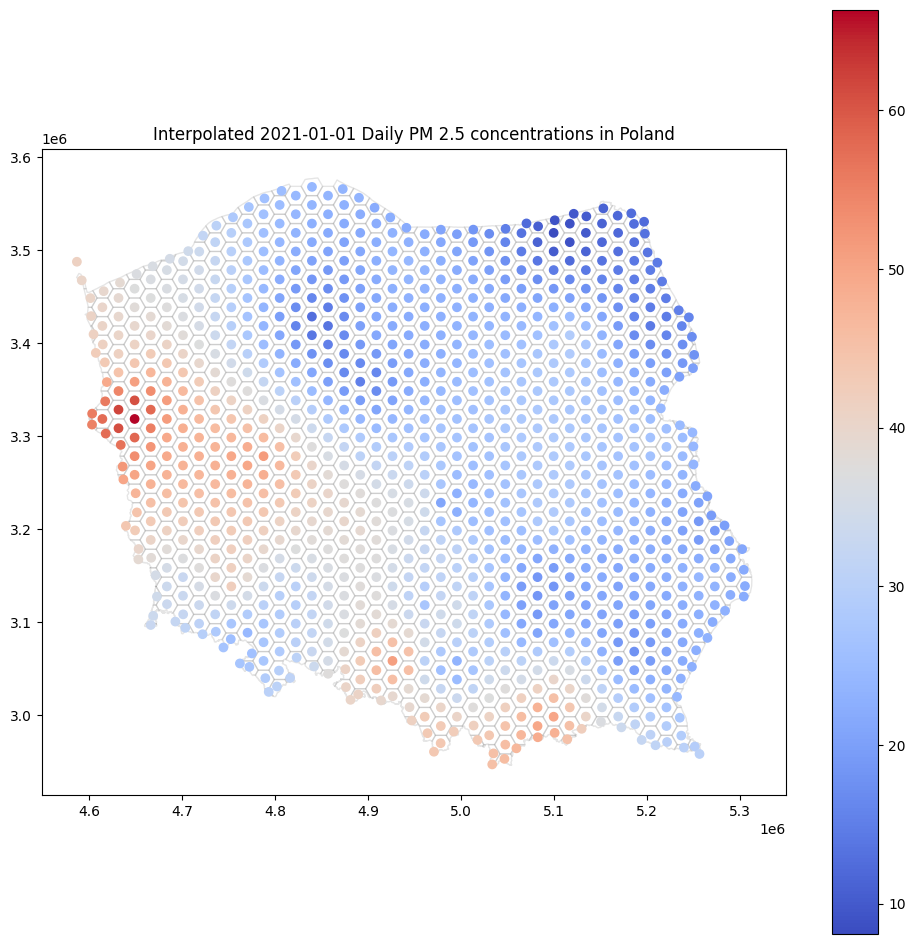

In [75]:
base = canvas.plot(color='white', edgecolor='black', alpha=0.1, figsize=(12, 12))
cdf.plot(ax=base, column='yhat', legend=True, cmap='coolwarm')
base.set_title('Interpolated 2021-01-01 Daily PM 2.5 concentrations in Poland');

---